In [31]:
# Use warpx_env as kernal
from PIL import Image
import numpy as np
import h5py
import scipy as sp # For finding the centroid
from scipy.ndimage import median_filter
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid, trapezoid, quad, quad_vec
from scipy.optimize import curve_fit
import matplotlib.transforms as transforms
from scipy.ndimage import gaussian_filter
from scipy.signal import savgol_filter
from scipy.signal import wiener
import scipy.constants as cons
from matplotlib.ticker import ScalarFormatter
from matplotlib.colors import LinearSegmentedColormap
from PIL import Image
from mpl_toolkits.mplot3d import Axes3D
from scipy.signal import find_peaks
import scipy
from scipy.interpolate import interp1d
from matplotlib.ticker import NullFormatter
import scipy.constants as sc
import math
import matplotlib.gridspec as gridspec
from scipy.interpolate import interp1d
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from lasy.laser import Laser
from lasy.profiles.gaussian_profile import GaussianProfile
from lasy.utils.laser_utils import get_full_field
from lasy.utils.laser_utils import get_duration, get_laser_fluence, get_laser_power, field_to_vector_potential,get_w0
from openpmd_viewer import OpenPMDTimeSeries
from openpmd_viewer import ParticleTracker
pi = cons.pi
clight = cons.speed_of_light
epsilon_0 = cons.epsilon_0
me = cons.electron_mass
qe = cons.elementary_charge
import sys
sys.path.append('/Users/victorflores/warpx_env/WarpX/Warpx_Sims/PIC_Helper')

from PIC_Helper import laser_plasma_para, sim_RZ_para, add_colorbar


### From experimental data

In [2]:
# max energy given ~ 8 J
# pulse duration 30 fs 
# best strehl ratio 0.6
laser_power = (8*0.6) / (30*10**-15) 

# Laser wavelength 
TA3_lam = 0.8e-6
# laser frequency
TA3_wl = (2*pi*clight)/TA3_lam
# Laser duration
TA3_tau = (30.e-15) / np.sqrt(2*np.log(2))
# Laser energy
TA3_energy = 8*0.6
# TA3 spot size 
TA3_spot = 25.e-6 / np.sqrt(2*np.log(2))
# Laser polarization
polarization = (1,0)

t_peak = 0.0  # Location of the peak of the laser pulse in time

TA3_intensity = 0.83*(TA3_energy / ((30.e-15) * (25.e-6)**2 ))

TA3_intensity_w_cm2 = TA3_intensity*(1/100)**2

TA3_a0 = 0.85*np.sqrt(TA3_intensity_w_cm2/10**18)*0.8

E_max = (TA3_a0*me*TA3_wl*clight)/qe

print(f"E_max = {E_max:.3e} V/m")

E_max = 1.258e+13 V/m


In [18]:
E_max

np.float64(12579918591356.17)

In [3]:
# Creating the TA3 laser 
laser_profile = GaussianProfile(
    TA3_lam, polarization, TA3_energy, TA3_spot, TA3_tau, t_peak
)

In [4]:
dimensions = "rt"  # Use cylindrical geometry
#But in Lasy, the idea is to represent the laser envelope (not the full field) in a reduced space, 
# and the t axis is actually the retarded time — not a simulation time or coordinate time in the usual sense.
lo = (0, -2.5 * TA3_tau)  # Lower bounds of the simulation box
hi = (5 * TA3_spot, 2.5 * TA3_tau)  # Upper bounds of the simulation box
num_points = (300, 500)  # Number of points in each dimension

laser = Laser(dimensions, lo, hi, num_points, laser_profile,n_azimuthal_modes=2)
laser.normalize(TA3_energy, kind="energy")

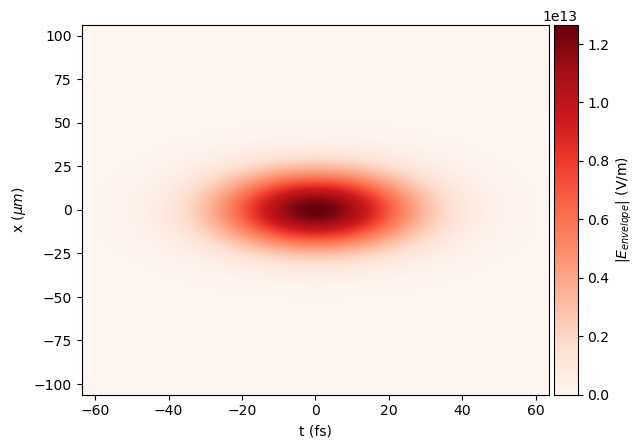

In [5]:
laser.show()

In [6]:
pos_antena = 20e-6 # The Rayleigh length
laser.propagate(-pos_antena)  # Propagate the pulse upstream of the focal plane

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

  0%|          | 00:00<? [?it/s]

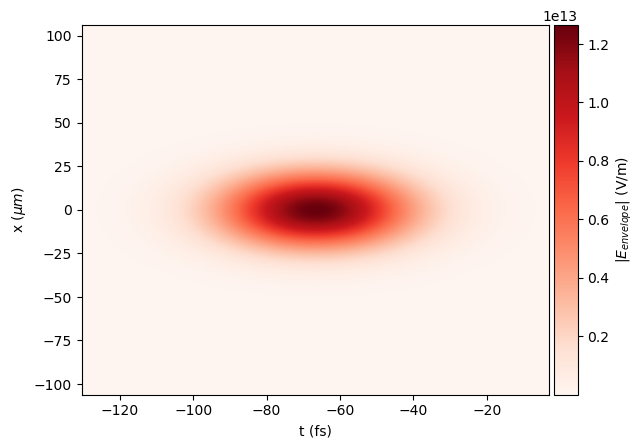

In [7]:
laser.show()

In [8]:
file_prefix = "/Users/victorflores/warpx_env/WarpX/Runs_Rz/Laser_Test/TA3_pulse"  # The file name will start with this prefix
file_format = "h5"  # Format to be used for the output fileq

laser.write_to_file(file_prefix, file_format)

In [10]:
delay = (20.e-6)/clight
delay

6.671281903963042e-14

In [33]:
path_Rz ='/Users/victorflores/warpx_env/WarpX/Runs_Rz/Laser_Test/diags/diag1'
data= OpenPMDTimeSeries("{}".format(path_Rz),backend="h5py")

In [34]:
# laser_plasma parameters
lam = 800e-9
dens = 0.001
a0 = 2
r = 50e-6
z = [-30.e-6,30.e-6]
ncells = [512,1024]
mode = 2
max_grid_size = [256,256]
gpus = 1

lp_para = laser_plasma_para(lam,dens,a0)
sim_para = sim_RZ_para(lam,r,z,ncells,mode,max_grid_size,gpus)



In [35]:
j = 8
t=data.t[j]
Ey, Ey_info = data.get_field(t=data.t[j], field='E',coord="y", plot=False)
#rho_ele, ele_info = data.get_field(t=data.t[j], field='rho_electrons', plot=False)
Ey_slice, Ey_info_slice = data.get_field(t=data.t[j], field='E',coord="y", plot=False, slice_across="r",slice_relative_position= 0)
Ez_slice, Ez_info_slice = data.get_field(t=data.t[j], field='E',coord="z", plot=False, slice_across="r",slice_relative_position= 0)
zmin = Ey_info.zmin
zmax = Ey_info.zmax
rmin = Ey_info.rmin
rmax = Ey_info.rmax
Ey_norm = Ey/lp_para['Enorm']
Ey_slice_norm = Ey_slice / lp_para['Enorm']
#delta_tho_ele = ((-rho_ele/q_e) - lp_para['ne0'])/ (lp_para['ne0'])
Z = np.linspace(zmin, zmax, len(Ey))
R = np.linspace(rmin, rmax, len(Ey[0]))

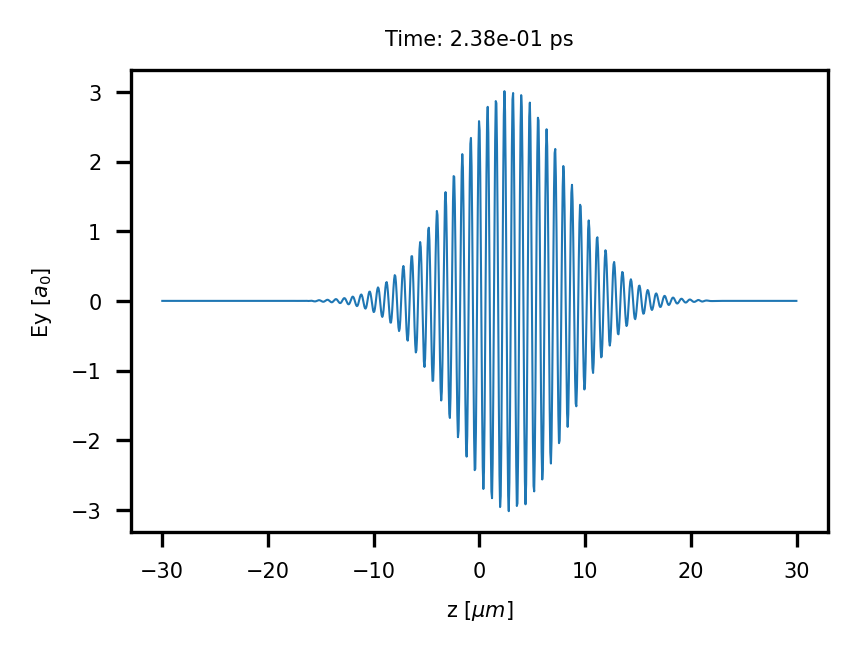

In [36]:
#####################################
fig_width = 3 # Set width to 1.5 inches
fig_height = 2  # Set height to 1.5 inches
fig, ax = plt.subplots(figsize=(fig_width, fig_height), dpi=300)
#charge_bg_dens = ax.pcolormesh(Z,X,rho_ele_dens.T,cmap='Spectral_r')
ax.plot(Z*10**6 , Ey_slice_norm, linewidth = 0.5)
#ax2 = ax.twinx()
#ax2.plot(Z*10**6 , Ez_slice, linewidth = 0.5,color='red')
ax.set_title('Time: {:.2e} ps'.format(t*10**12),fontsize=5)
ax.tick_params('x',labelsize=5)
ax.tick_params('y',labelsize=5)
ax.set_ylabel(r'Ey [$a_0$]', fontsize = 5)
ax.set_xlabel(r'z [$\mu m$]', fontsize = 5)
plt.show()

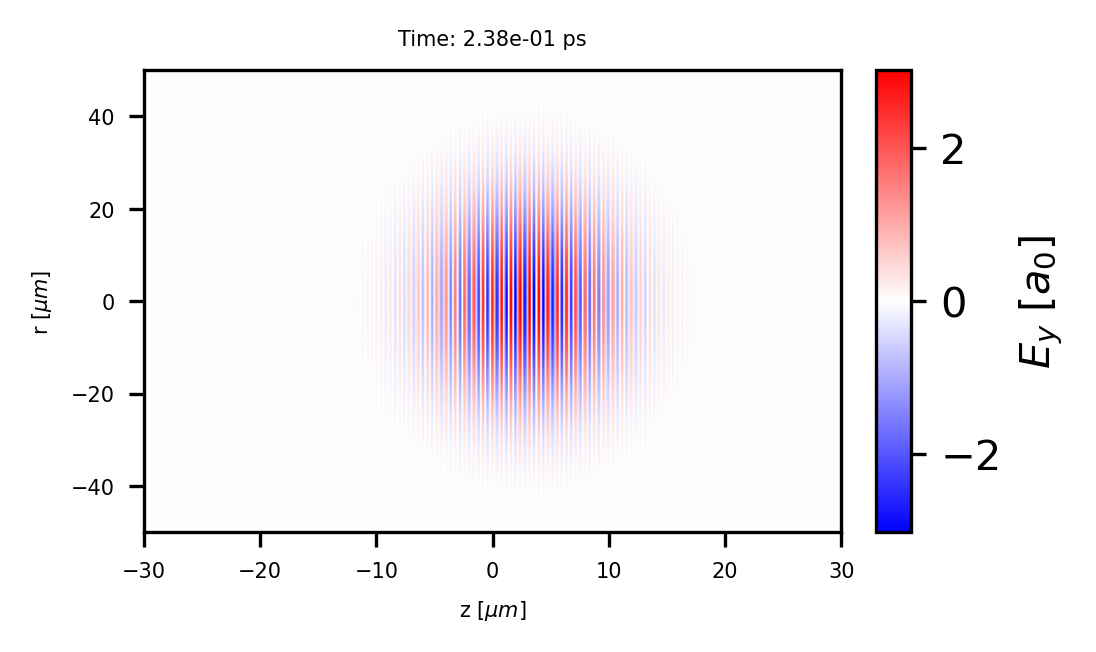

In [37]:
#####################################
fig_width = 3 # Set width to 1.5 inches
fig_height = 2  # Set height to 1.5 inches
fig, ax = plt.subplots(figsize=(fig_width, fig_height), dpi=300)
#charge_bg_dens = ax.pcolormesh(Z,X,rho_ele_dens.T,cmap='Spectral_r')
Ey_field = ax.pcolormesh(Z *10**6, R*10**6, Ey_norm.T, cmap='bwr')
cb1 = add_colorbar(Ey_field)
cb1.set_label('$E_y$ [$a_0$]')
ax.set_title('Time: {:.2e} ps'.format(t*10**12),fontsize=5)
ax.tick_params('x',labelsize=5)
ax.tick_params('y',labelsize=5)
ax.set_ylabel(r'r [$\mu m$]', fontsize = 5)
ax.set_xlabel(r'z [$\mu m$]', fontsize = 5)
plt.show()